<a href="https://colab.research.google.com/github/npzz/collab/blob/master/mlb_pitch_type_predict_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

data volume is high. evalating yearly distribution that can be dervied from first characters from ab_id. converting ab_id to integer as it incorrectly read as float 

## 2019 data

#### Motivation 
Aim of section of the project is to predict what type of pitch will be coming next based on various metrics from previous pitch. As there are many measured metrics associated to pitch from velocity of pitch to handedness of pitcher, there will be feature selection also implemented to reduce number of dimension to important set.

In [ ]:
# using 2019 data
p19_master = pd.read_csv("/content/2019_pitches.csv")
ab19_master = pd.read_csv("/content/2019_atbats.csv")

In [ ]:
# making a working copy
p19 = p19_master
ab19 = ab19_master

In [ ]:
p19_master.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,sz_bot,sz_top,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone,code,type,pitch_type,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,0.00,2.15,88.8,80.7,placeholder,placeholder,22.8,4.8,24.0,-8.47,28.90,-15.51,1.70,3.36,placeholder,5.28,-128.95,-6.89,116.97,-1.42,180.81,50.0,6.07,-5.07,9.98,NaN,placeholder,X,X,FF,5,0.0,2.019000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.34,2.31,89.9,81.8,placeholder,placeholder,22.8,3.6,24.0,-7.10,28.85,-12.99,1.80,3.55,placeholder,4.89,-130.54,-7.48,103.93,-1.02,176.34,50.0,6.20,-4.14,11.18,NaN,placeholder,C,C,FF,8,0.0,2.019000e+09,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,-0.05,2.03,85.7,79.6,placeholder,placeholder,9.6,6.0,24.0,3.65,22.07,-22.64,1.59,3.55,placeholder,2.33,-124.60,-5.98,118.86,-1.29,183.96,50.0,6.30,2.30,5.99,NaN,placeholder,S,S,SL,9,0.0,2.019000e+09,0.0,0.0,1.0,2.0,0.0,0.0,0.0
3,0.49,0.92,85.4,78.5,placeholder,placeholder,24.0,7.2,24.0,-13.77,24.44,-25.74,1.74,3.55,placeholder,7.83,-123.74,-6.78,98.15,-1.56,214.03,50.0,5.85,-8.87,4.14,NaN,placeholder,B,B,CH,10,0.0,2.019000e+09,0.0,1.0,1.0,3.0,0.0,0.0,0.0
4,-0.13,1.11,84.6,77.6,placeholder,placeholder,26.4,8.4,24.0,-15.99,24.56,-28.36,1.83,3.59,placeholder,6.79,-122.67,-5.73,121.81,-1.57,208.77,50.0,5.89,-10.51,2.51,NaN,placeholder,B,B,CH,11,0.0,2.019000e+09,1.0,1.0,1.0,4.0,0.0,0.0,0.0


### EDA

In [ ]:
# keeping only important attribute or least those have meaning defined on the data source
keep_columns = ['pitch_type','type','ab_id','pitch_num','vx0','vy0','vz0','ax',
                'ay','az','break_angle','break_length','break_y'
               ]
p19 = p19_master[keep_columns]

In [ ]:
## checking for Nulls
p19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728790 entries, 0 to 728789
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   pitch_type    722161 non-null  object 
 1   type          728790 non-null  object 
 2   ab_id         728790 non-null  float64
 3   pitch_num     728790 non-null  float64
 4   vx0           722161 non-null  float64
 5   vy0           722161 non-null  float64
 6   vz0           722161 non-null  float64
 7   ax            722161 non-null  float64
 8   ay            722161 non-null  float64
 9   az            722161 non-null  float64
 10  break_angle   722161 non-null  float64
 11  break_length  722161 non-null  float64
 12  break_y       722161 non-null  float64
dtypes: float64(11), object(2)
memory usage: 72.3+ MB


In [ ]:
ab19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185245 entries, 0 to 185244
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   inning      185245 non-null  float64
 1   top         185245 non-null  float64
 2   ab_id       185245 non-null  float64
 3   g_id        185245 non-null  float64
 4   p_score     185245 non-null  float64
 5   batter_id   185245 non-null  int64  
 6   pitcher_id  185245 non-null  int64  
 7   stand       185245 non-null  object 
 8   p_throws    185245 non-null  object 
 9   event       185245 non-null  object 
 10  o           185245 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 15.5+ MB


##### Findings from info on pitches and atbat dataset
1.) there are NULLs in pitch type those need to be removed.
2.) "ab_id" which is the key joining two dataset is of type float in pitches are int on atbat.This will be converted to "int" from float on pitches dataset.

In [ ]:
# drop missing pitch type
p19 = p19[~p19.pitch_type.isna()]

In [ ]:
# converting datatype to more comprehensible and rename column
p19['ab_id'] = p19['ab_id'].astype('int') # this can be used to join with atbats
ab19['ab_id'] = ab19['ab_id'].astype('int') # this can be used to join with atbats

##### Distribution Plot 
below shows number of pitches is Four-Finger Fast Ball (FF) and then somewhat close to slower balls like Slider(SL),ChangeUp(CH), CurveBall(CU).  Thus dividing the dataset into two categories in Fast-Ball and Not-Fast-Balls will give  failry close to normal distribution.

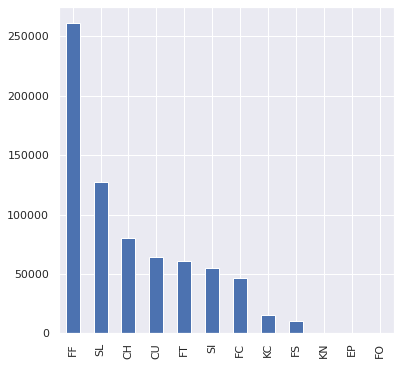

In [ ]:
# YOUR CODE
p19.pitch_type.value_counts().plot(kind='bar',figsize=(6,6));

##### Condensing Pitch Type

In [ ]:
# Condense Pitch Type
# parsing pitch_type into broad category of 'fastball' and 'off-speed'
# classification taken from https://library.fangraphs.com/pitch-type-abbreviations-classifications/

fast_ball_pitch_type = ['FA','FF','FT','FC','FS','SI','SF']
off_type_pitch_type = ['SL','CH','CB','CU','KC','KN','EP']
p19['pitch_type'] = np.where(p19['pitch_type']\
                                     .isin(fast_ball_pitch_type), 
                                     1, 0
                                    )

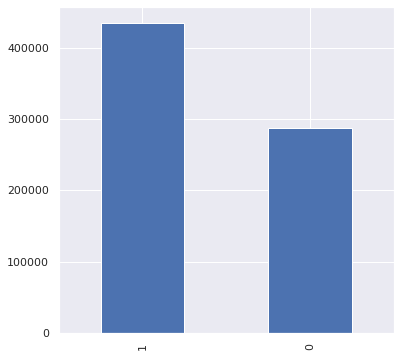

In [ ]:
p19.pitch_type.value_counts().plot(kind='bar',figsize=(6,6));

Above plot shows distribution of Fast-Ball/Not-Fast-Ball and it is not very imbalanced so there should not be overfitting in the model.

In [ ]:
# joining pitcher and at-bats dataset to get pithcer id
# this is needed to make groups to calculate previous itch metric of the pitcher
pab = pd.merge(p19,ab19,on="ab_id")

In [ ]:
# removing id colums after join and keeping only meaninful attributes
cols_to_keep = ['pitch_type','type','ab_id','pitcher_id','pitch_num','vx0','vy0','vz0','ax',
                'ay','az','break_angle','break_length','break_y','stand','p_throws']
pab = pab[cols_to_keep]

In [ ]:
# transforming stand and p_throw as new variable : batter_pitcher_same_side
pab['batter_pitcher_same_side'] = np.where(pab['stand']==pab['p_throws'],1,0)

In [ ]:
#dropping p_throws and stand
pab.drop(['p_throws','stand'],axis=1,inplace=True)

##### creating dummy variable for outcome of pitch

In [ ]:
# adding meaningful name to type and making dummies
pab['type'] = pab.type.map({"B":"ball","S":"strike","X":"in-play","C":"catch"})

In [ ]:
# creating dummy values for type
pab = pd.concat([pab.drop('type', axis=1), pd.get_dummies(pab['type'])], axis=1)

##### Previous Metrics Calculation

In [ ]:
## adding previous attributes
previous_to_be_calculated = ['pitch_type','vx0','vy0','vz0','ax',
                             'ay','az','break_angle','break_length',
                             'break_y','ball',
                             'catch','in-play','strike'
               ]
for col in previous_to_be_calculated:
    previous_col_name = "previous_"+col
    pab[previous_col_name] = pab.sort_values(by=['pitch_num'], ascending=True).groupby(['pitcher_id','ab_id'])[col].shift(1)

In [ ]:
## replacing NaN on previous metrics to UN
pab['previous_pitch_type'].fillna('UN', inplace=True)

##### Dropping NULLs  
After adding previous features,there are hearty volume of NULLs for case where a pithcer has only thrown one pitch to a particular batter. Since our model focussed on predicting based on past events; these records are safe to drop.

In [ ]:
print("Dataset shape before drop of NaN/NULL previous metric:",pab.shape)

Dataset shape before drop of NaN/NULL previous metric: (722161, 32)


In [ ]:
## dropping all rows with NA
pab.dropna(inplace=True)
print("Dataset shape after drop of NaN/NULL previous metric:",pab.shape)

Dataset shape after drop of NaN/NULL previous metric: (538485, 32)


In [ ]:
## taking previous set and building model
pab_previous = pab[['pitch_type','previous_pitch_type', 'previous_vx0', 'previous_vy0', 'previous_vz0',
       'previous_ax', 'previous_ay', 'previous_az', 'previous_break_angle',
       'previous_break_length', 'previous_break_y', 'previous_ball',
       'previous_catch', 'previous_in-play', 'previous_strike']]

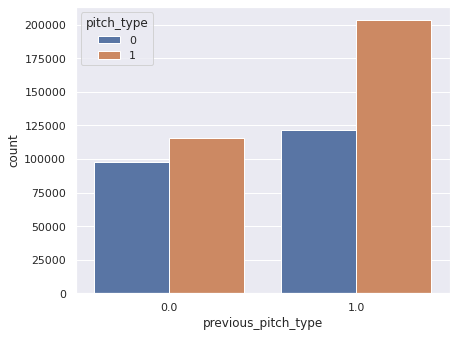

In [ ]:
sns.set(rc={'figure.figsize':(6.7,5.27)}) # sets size of the figure
sns.countplot(x="previous_pitch_type",hue="pitch_type",data=pab)
plt.show()

Above plot shows relationship between pitch type and previous pitch type. This shows most of the time a fast pitch is followed by some type of fast pitch and a slow pitch also more often that not is followed by a fast ball.

### Feature Selection

In [ ]:
# making Predictor-Response set
y_NP=pab_previous.pitch_type
X_NP=pab_previous.drop('pitch_type',axis=1)

In [ ]:
# train test split
X_NP_train, X_NP_test, y_NP_train, y_NP_test = train_test_split(X_NP, y_NP, test_size=0.10, random_state=555)
X_NP_train, X_NP_val, y_NP_train, y_NP_val = train_test_split(X_NP_train, y_NP_train, test_size=0.30, random_state=555)

#### Random Forest : Feature Selection  
RF provides feature importances based on mean decrease in impurity that is used to do feature selection.

In [ ]:
# fitting random forest to find best features
from sklearn.ensemble import RandomForestClassifier
forest_NP = RandomForestClassifier(random_state=0)
forest_NP.fit(X_NP_train, y_NP_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
importances = forest_NP.feature_importances_ # importances measures in gini index
std = np.std([tree.feature_importances_ for tree in forest_NP.estimators_], axis=0)

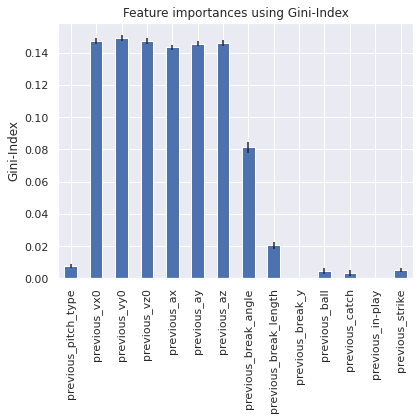

In [ ]:
# plotting to visualize most informational features based on Mean Decrease in Impurity
feature_names = X_NP_train.columns.tolist()
forest_importances = pd.Series(importances, index=feature_names)
fig = plt.figure()
ax = fig.add_subplot(111)
forest_importances.plot.bar(yerr=std, ax=ax,figsize=(6,6))
ax.set_title("Feature importances using Gini-Index")
ax.set_ylabel("Gini-Index")
fig.tight_layout()

Above plot shows high correlation with previous velocity and acceleration attributes with pitch_type. Previous Break angle turns out important as well followed by previous ball and catch.

In [ ]:
# using above start_speed,end_speed,vy0,ay,az,break_length,pfx_z are the most informative ones
important_columns = ['previous_pitch_type', 'previous_vy0',
       'previous_ay', 'previous_break_angle',
       'previous_break_length', 'previous_ball',
       'previous_catch', 'previous_strike']

In [ ]:
## building dataset with important columns
X_NP_train = X_NP_train[important_columns]
X_NP_test = X_NP_test[important_columns]
X_NP_val = X_NP_val[important_columns]

### Model Building : Logistic Regression

In [ ]:
logi_NP = LogisticRegression(max_iter = 10000, solver='lbfgs', penalty='l2', C=0.1)
logi_NP.fit(X_NP_train,y_NP_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##### Predict/CM-CF Matrix: Train

Classification Report of Training Set
              precision    recall  f1-score   support

           0       0.46      0.05      0.09    138434
           1       0.59      0.96      0.73    200811

    accuracy                           0.59    339245
   macro avg       0.53      0.51      0.41    339245
weighted avg       0.54      0.59      0.47    339245



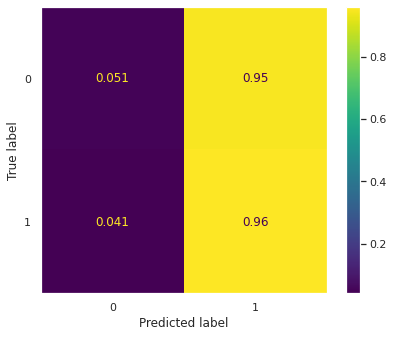

In [ ]:
pred_train_NP = logi_NP.predict(X_NP_train)
target_name=[1,0]
plot_confusion_matrix(logi_NP, X_NP_train,y_NP_train,normalize="true")
plt.grid(False)
print("Classification Report of Training Set")
print(classification_report(y_NP_train, pred_train_NP))

##### Predict/CM-CF Matrix: Validation¶

Classification Report of Validation Set
              precision    recall  f1-score   support

           0       0.48      0.05      0.10     59531
           1       0.59      0.96      0.73     85860

    accuracy                           0.59    145391
   macro avg       0.54      0.51      0.41    145391
weighted avg       0.55      0.59      0.47    145391



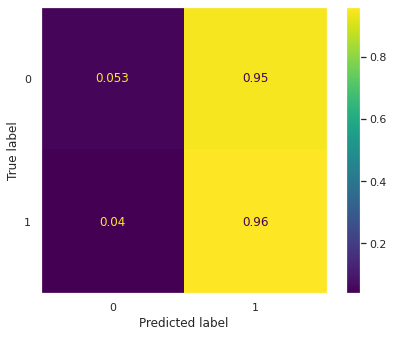

In [ ]:
pred_val_NP = logi_NP.predict(X_NP_val)
target_name=[1,0]
plot_confusion_matrix(logi_NP, X_NP_val,y_NP_val,normalize="true")
plt.grid(False)
print("Classification Report of Validation Set")
print(classification_report(y_NP_val, pred_val_NP))

#### Analysis  
Calssification Report shows that Logistic regression is not very good in identifying pitch_type class:1 i.e. Fast Ball however since most of the pitches are fast ball; a good model should be able to identify pitch type class : 0 i.e. Off-speed. This could be because of imbalanced data. To overcome the imbalance,we can try using *class_weight* hyper-paramter by assigning more weight to class 0 compared to class 1in logistic regression and test if it makes any difference. Below is implementation of same.

#### Hyper-Parameter Tuning

In [ ]:
w = [{0:1000,1:100},{0:1000,1:10}, {0:100,1:1.0}, {0:10,1:1.0} ] # giving set of hyper param with more weight to class 0.
hyperparam_grid = {"class_weight": w }

In [ ]:
from sklearn.model_selection import GridSearchCV
logi_NP = LogisticRegression(max_iter = 10000, solver='lbfgs', penalty='l2', C=0.1)
# define evaluation procedure
logi_grid = GridSearchCV(logi_NP,hyperparam_grid, cv=5,n_jobs=-1, refit=True)
logi_grid.fit(X_NP_train,y_NP_train)
print(f'Best score: {logi_grid.best_score_} with param: {logi_grid.best_params_}')

Best score: 0.40806496779613555 with param: {'class_weight': {0: 1000, 1: 100}}


In [ ]:
logi_NP = LogisticRegression(max_iter = 10000, solver='lbfgs',penalty='l2', C=0.1,class_weight=logi_grid.best_params_['class_weight'])


In [ ]:
logi_NP.fit(X_NP_train,y_NP_train)

LogisticRegression(C=0.1, class_weight={0: 1000, 1: 100}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

Classification Report of Training Set


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.41      1.00      0.58    138434
           1       0.00      0.00      0.00    200811

    accuracy                           0.41    339245
   macro avg       0.20      0.50      0.29    339245
weighted avg       0.17      0.41      0.24    339245



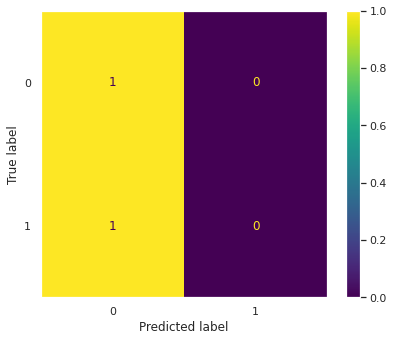

In [ ]:
pred_train_NP = logi_NP.predict(X_NP_train)
target_name=[1,0]
plot_confusion_matrix(logi_NP, X_NP_train,y_NP_train,normalize="true")
plt.grid(False)
print("Classification Report of Training Set")
print(classification_report(y_NP_train, pred_train_NP))

#### Analysis
best score of class weight Grid Search above is making model worse by only predicting class 0 now since it was given more weight. The approach to do inverse class weight is discarded.

### Model Building : Random Forest

As logistic regression in default and also hyper parametrized did not work; moving onto running a Random Forest(RF) classification. RF algorithms are better in predicting imbalanced data since 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_NP_train, y_NP_train)

In [ ]:
# predict on val set
rfc_val_pred = rfc.predict(X_NP_val)


In [ ]:
target_name=[1,0]
# plot_confusion_matrix(rfc, X_NP_val,y_NP_val)
# plt.grid(False)
print("Classification Report of Validation Set")
print(classification_report(y_NP_val, rfc_val_pred))

Classification Report of Validation Set
              precision    recall  f1-score   support

           0       0.44      0.44      0.44     59531
           1       0.61      0.60      0.61     85860

    accuracy                           0.54    145391
   macro avg       0.52      0.52      0.52    145391
weighted avg       0.54      0.54      0.54    145391



#### Analysis
 RF in default straight away shows improvement in predicting minority class when we compare recall to Logistic Regression ( RF : 0.45 wherein Logistic REgression was 0.05).Accuracy has not changed and is in the same range as Logistic Regression so RF model seems to perform better here.

#### Hyper-Parameter Tuning

In [ ]:
# implementing Weighted Random Forest
rfc_grid = GridSearchCV(RandomForestClassifier(n_estimators=10),hyperparam_grid, cv=5,n_jobs=-1, refit=True)
rfc_grid.fit(X_NP_train,y_NP_train)
print(f'Best score: {rfc_grid.best_score_} with param: {rfc_grid.best_params_}')

Best score: 0.5417618535276865 with param: {'class_weight': {0: 100, 1: 1.0}}


In [ ]:
# using best score in RF
rfc = RandomForestClassifier(n_estimators=10,class_weight=rfc_grid.best_params_['class_weight'])

In [ ]:
rfc.fit(X_NP_train, y_NP_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 100, 1: 1.0}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [ ]:
# predict on val set
rfc_val_pred = rfc.predict(X_NP_val)

In [ ]:
target_name=[1,0]
# plot_confusion_matrix(rfc, X_NP_val,y_NP_val)
# plt.grid(False)
print("Classification Report of Validation Set")
print(classification_report(y_NP_val, rfc_val_pred))

Classification Report of Validation Set
              precision    recall  f1-score   support

           0       0.44      0.41      0.42     59531
           1       0.61      0.64      0.62     85860

    accuracy                           0.54    145391
   macro avg       0.52      0.52      0.52    145391
weighted avg       0.54      0.54      0.54    145391



#### Analysis
Not much change with weighted RF compared to default fitted RF model in minority class.However recall to identify class 1 increased from 0.60 in default balanced weight RF model to 0.64 in weighted RF model. using weighted RF model will be better here since data imbalance is facotred into the fit of the model.

### Final Model

From all the model fitted above, Random Forest with weighted class is the best. Predicting using test data and evulating classification matrix of test data.

In [ ]:
rfc_test_pred = rfc.predict(X_NP_test)

In [ ]:
target_name=[1,0]
# plot_confusion_matrix(rfc, X_NP_val,y_NP_val)
# plt.grid(False)
print("Classification Report of Test Set")
print(classification_report(y_NP_test, rfc_test_pred))

Classification Report of Test Set
              precision    recall  f1-score   support

           0       0.44      0.41      0.43     21987
           1       0.61      0.64      0.62     31862

    accuracy                           0.55     53849
   macro avg       0.53      0.53      0.53     53849
weighted avg       0.54      0.55      0.54     53849



#### Analysis

Test set gives almost same recall/precision/accuracy as compared to validaiton set. There is 0.01 point increase in recall for minority class. Accuracy being the same as validation shows there is no overfitting.